<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/train_pretext_1_label_eurosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will be used to train the pretext task on eurosat data with any 1 label

## 0. Installations and imports

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 53.4 MB/s eta 0:00:00


In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create a folder for model checkpoints

%cd /home
!sudo mkdir checkpoints

/home


In [ ]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import segmentation_models_pytorch as smp
import csv
from PIL import Image
from scipy.ndimage import zoom
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.display import display
from skimage import io

## 2. Define the hyperparameters

In [ ]:
AUXILIARY_DATASOURCE = 'BUILT' # 'LC', 'POP', 'BUILT'
LR = 0.001

## 3. Prepare the dataloaders

In [ ]:
# the labels are saved on my google drive
BUILT_path_eurosat = '/content/drive/MyDrive/eurosat_BUILT'
LC_path_eurosat = '/content/drive/MyDrive/eurosat_LC'


test_train_images_path = '/content/drive/MyDrive/EuroSAT_MS_test'
train_images_path = '/content/drive/MyDrive/EuroSAT_MS'



In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/EuroSAT_MS/pretext_train_data.csv', header=None)
train_data

0  \
0     HerbaceousVegetation/HerbaceousVegetation_1170...   
1                        Residential/Residential_59.tif   
2                                  River/River_1162.tif   
3     HerbaceousVegetation/HerbaceousVegetation_1205...   
4                          AnnualCrop/AnnualCrop_75.tif   
...                                                 ...   
7123  HerbaceousVegetation/HerbaceousVegetation_151.tif   
7124               PermanentCrop/PermanentCrop_1087.tif   
7125                       Industrial/Industrial_65.tif   
7126  HerbaceousVegetation/HerbaceousVegetation_404.tif   
7127                PermanentCrop/PermanentCrop_373.tif   

                                        1  
0     HerbaceousVegetation_1170_label.npy  
1                Residential_59_label.npy  
2                    River_1162_label.npy  
3     HerbaceousVegetation_1205_label.npy  
4                 AnnualCrop_75_label.npy  
...                                   ...  
7123   HerbaceousVegetation_151_label.npy  
7124         PermanentCrop_1087_label.npy  
7125              Industrial_65_label.npy  
7126   HerbaceousVegetation_404_label.npy  
7127          PermanentCrop_373_label.npy  

[7128 rows x 2 columns]

In [ ]:
train_data_subset = pd.read_csv('/content/drive/MyDrive/EuroSAT_MS/pretext_train_data_subset.csv', header=None)
train_data_subset

0  \
0    HerbaceousVegetation/HerbaceousVegetation_1914...   
1                              Pasture/Pasture_769.tif   
2                              SeaLake/SeaLake_620.tif   
3                               Forest/Forest_1731.tif   
4                      Residential/Residential_897.tif   
..                                                 ...   
295                              Forest/Forest_729.tif   
296  HerbaceousVegetation/HerbaceousVegetation_386.tif   
297  HerbaceousVegetation/HerbaceousVegetation_363.tif   
298   HerbaceousVegetation/HerbaceousVegetation_41.tif   
299  HerbaceousVegetation/HerbaceousVegetation_751.tif   

                                       1  
0    HerbaceousVegetation_1914_label.npy  
1                  Pasture_769_label.npy  
2                  SeaLake_620_label.npy  
3                  Forest_1731_label.npy  
4              Residential_897_label.npy  
..                                   ...  
295                 Forest_729_label.npy  
296   HerbaceousVegetation_386_label.npy  
297   HerbaceousVegetation_363_label.npy  
298    HerbaceousVegetation_41_label.npy  
299   HerbaceousVegetation_751_label.npy  

[300 rows x 2 columns]

In [ ]:
val_data = pd.read_csv('/content/drive/MyDrive/EuroSAT_MS/pretext_val_data.csv', header=None)
val_data

0  \
0                                 Forest/Forest_913.tif   
1                              Highway/Highway_1488.tif   
2                              SeaLake/SeaLake_1598.tif   
3     HerbaceousVegetation/HerbaceousVegetation_2796...   
4                              Highway/Highway_1127.tif   
...                                                 ...   
1777  HerbaceousVegetation/HerbaceousVegetation_179.tif   
1778                           SeaLake/SeaLake_1060.tif   
1779                           Pasture/Pasture_1008.tif   
1780                             Forest/Forest_1329.tif   
1781                   Residential/Residential_1192.tif   

                                        1  
0                    Forest_913_label.npy  
1                  Highway_1488_label.npy  
2                  SeaLake_1598_label.npy  
3     HerbaceousVegetation_2796_label.npy  
4                  Highway_1127_label.npy  
...                                   ...  
1777   HerbaceousVegetation_179_label.npy  
1778               SeaLake_1060_label.npy  
1779               Pasture_1008_label.npy  
1780                Forest_1329_label.npy  
1781           Residential_1192_label.npy  

[1782 rows x 2 columns]

In [ ]:
val_data_subset =  pd.read_csv('/content/drive/MyDrive/EuroSAT_MS/pretext_val_data_subset.csv', header=None)
val_data_subset

0                             1
0                Highway/Highway_403.tif         Highway_403_label.npy
1               Highway/Highway_1186.tif        Highway_1186_label.npy
2                Highway/Highway_566.tif         Highway_566_label.npy
3   PermanentCrop/PermanentCrop_2137.tif  PermanentCrop_2137_label.npy
4                  Forest/Forest_758.tif          Forest_758_label.npy
..                                   ...                           ...
75      Residential/Residential_1823.tif    Residential_1823_label.npy
76         AnnualCrop/AnnualCrop_483.tif      AnnualCrop_483_label.npy
77      Residential/Residential_1650.tif    Residential_1650_label.npy
78        Industrial/Industrial_1786.tif     Industrial_1786_label.npy
79                Forest/Forest_1653.tif         Forest_1653_label.npy

[80 rows x 2 columns]

In [ ]:
# functions needed for the loading of the data

def getArrFlood(fname):
    """Load .tif data into array"""
    return rasterio.open(fname).read()

def iloader(path):
    image = np.asarray((io.imread(path))/5000,dtype='float32')
    return image.transpose(2,0,1)

def download_data_from_list_singlelabel(l):
    """
    Download and prepare training data from file list.

    Gets training_list from load_flood_train_data
    downloads/reads each of the files (image and the 1 label) for each row
    returns a list of tuples, where teh first entry is the array of the image, and the second is a list of the label array
    """
    i = 0
    flood_data = []
    for (im_fname, mask_fname1) in l:
        if os.path.exists(mask_fname1):
          # Load the satelite image with rasterio (it is a .tif)
          arr_x = iloader(im_fname)

          # Load masks from different roots using numpy
          arr_y1 = np.load(mask_fname1)

          if i % 100 == 0:
            print(im_fname)
          i += 1

          flood_data.append((arr_x, [arr_y1]))

    return flood_data

def load_flood_train_data_multilabel(input_root, label_root_1):
    """
    Load training data including single label defined above in step 2 from specified roots.

    creates training_list that it hands over to next function: download_flood_water_data_from_list

    training_list has length of the training dataset csv + 1 (because it also creates path for the header, this will be discarded later on as it will not pass the .is_file() check
    each entry of the training_list is a tuple with 2 paths: image_path, label_path1
    """
    fname = "/content/drive/MyDrive/EuroSAT_MS/pretext_train_data_subset.csv" # train_data_subset / test_train_filenames / S1weak_train_filenames_final
    training_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            image_path = os.path.join(input_root, line[0])
            label_path1 = os.path.join(label_root_1, line[1])
            training_files.append((image_path, label_path1))

    return  download_data_from_list_singlelabel(training_files)

def load_flood_valid_data_multilabel(input_root, label_root_1):
    """
    Load validation data including label from specified roots.

    creates validation_list that it hands over to next function: download_flood_water_data_from_list

    validation_list has length of the validation dataset csv + 1 (because it also creates path for the header, this will be discarded later on as it will not pass the .is_file() check
    each entry of the validation_list is a tuple with 2 paths: image_path, label_path1
    """
    fname = "/content/drive/MyDrive/EuroSAT_MS/pretext_val_data_subset.csv" # val_data_subset / test_val_filenames / S1weak_val_filenames_final
    val_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            image_path = os.path.join(input_root, line[0])
            label_path1 = os.path.join(label_root_1, line[1])
            val_files.append((image_path, label_path1))

    return download_data_from_list_singlelabel(val_files)

In [ ]:
# functions needed for the processing of the labels

quantiles_built = [1.000e+00, 9.200e+01, 7.140e+02, 1.532e+03, 2.165e+03, 6.375e+03]

def make_BUILT_categorical(array_label):
  categorical_label = np.digitize(array_label, quantiles_built, right=True)

  categorical_label = categorical_label.astype(np.uint8)
  return categorical_label

# possible LC label values
possible_label_vals = [20,  30,  40,  50,  60,  70,  80,  90, 100, 111, 114, 115, 116,
       121, 124, 125, 126, 200]

# create a mapping dictioanry
label_to_class_id = {label: idx for idx, label in enumerate(possible_label_vals)}
vectorized_map = np.vectorize(label_to_class_id.get, otypes=[np.uint32])

def class_id_transformation_LC(array_label):
  """
  Transforms all LC label values to class_id values. The class IDs are defined above
  """
  return vectorized_map(array_label)

def resize_the_label_for_eurosat(array_label):
  """
  Resizes each label to the Senfloods image size of 512 x 512.
  BUILT & POP are resized with order = 1, a liniear interpolation
  LC is resized with order = 0, a nearest neighbor technique
  """
  original_shape = array_label.shape

  new_shape = (64, 64) # this is a senfloods specific function

  zoom_factors = [n / o for n, o in zip(new_shape, original_shape)]

  resized_label = zoom(array_label, zoom_factors, order = 0)

  return resized_label

In [ ]:
# the actual processing function for training data

def processAndAugmentMultipleLabels(data):
  """
  Preprocessing of training data (images and labels).

  Labels are scaled and resized.

  Random cropping to 256 x 256 and horizontal & vertical flipping of images & labels.

  Normalization of images with mean and standard deviation.

  Stacking of tensor image channels (2, 256, 256) and tensor labels (2, 256, 256)
  """
  (x, ys) = data
  im = x.copy() # (13,64,64), array
  labels = [y.copy() for y in ys] # list of 1 array, shape 6,10
  # # depening on AUXILIARY-DATASOURCE do different preprocessing
  # # hier findet label processing statt

  if AUXILIARY_DATASOURCE == 'BUILT':
    #labels[0] = log_scale_label(labels[0])
    #labels[0] = min_max_scale_BUILT(labels[0])
    labels[0] = make_BUILT_categorical(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0])
  elif AUXILIARY_DATASOURCE == 'LC':
    labels[0] = class_id_transformation_LC(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0]) # jetzt shape 64,64

  # Convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  im3 = Image.fromarray(im[2])
  im4 = Image.fromarray(im[3])
  im5 = Image.fromarray(im[4])
  im6 = Image.fromarray(im[5])
  im7 = Image.fromarray(im[6])
  im8 = Image.fromarray(im[7])
  im9 = Image.fromarray(im[8])
  im10 = Image.fromarray(im[9])
  im11 = Image.fromarray(im[10])
  im12 = Image.fromarray(im[11])
  im13 = Image.fromarray(im[12])
  labels = [Image.fromarray(label.squeeze()) for label in labels]

  # do the random rotation (but the same one to all)
  random_int = random.randint(-3,3)
  angle = random_int * 90

  im1 = im1.rotate(angle)
  im2 = im2.rotate(angle)
  im3 = im3.rotate(angle)
  im4 = im4.rotate(angle)
  im5 = im5.rotate(angle)
  im6 = im6.rotate(angle)
  im7 = im7.rotate(angle)
  im8 = im8.rotate(angle)
  im9 = im9.rotate(angle)
  im10 = im10.rotate(angle)
  im11 = im11.rotate(angle)
  im12 = im12.rotate(angle)
  im13 = im13.rotate(angle)


  if random.random() > 0.5:
      im1 = F.hflip(im1)
      im2 = F.hflip(im2)
      im3 = F.hflip(im3)
      im4 = F.hflip(im4)
      im5 = F.hflip(im5)
      im6 = F.hflip(im6)
      im7 = F.hflip(im7)
      im8 = F.hflip(im8)
      im9 = F.hflip(im9)
      im10 = F.hflip(im10)
      im11 = F.hflip(im11)
      im12 = F.hflip(im12)
      im13 = F.hflip(im13)
      labels = [F.hflip(label) for label in labels]
  if random.random() > 0.5:
      im1 = F.vflip(im1)
      im2 = F.vflip(im2)
      im3 = F.vflip(im3)
      im4 = F.vflip(im4)
      im5 = F.vflip(im5)
      im6 = F.vflip(im6)
      im7 = F.vflip(im7)
      im8 = F.vflip(im8)
      im9 = F.vflip(im9)
      im10 = F.vflip(im10)
      im11 = F.vflip(im11)
      im12 = F.vflip(im12)
      im13 = F.vflip(im13)
      labels = [F.vflip(label) for label in labels]

  norm = transforms.Normalize([0.2703, 0.2232, 0.2084, 0.1894, 0.2401, 0.4013, 0.4757, 0.4612, 0.1468,
          0.0024, 0.3646, 0.2237, 0.5209], [0.0484, 0.0663, 0.0787, 0.1184, 0.1126, 0.1717, 0.2170, 0.2235, 0.0811,
          0.0009, 0.2001, 0.1517, 0.2461])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(),
                    transforms.ToTensor()(im2).squeeze(),
                    transforms.ToTensor()(im3).squeeze(),
                    transforms.ToTensor()(im4).squeeze(),
                    transforms.ToTensor()(im5).squeeze(),
                    transforms.ToTensor()(im6).squeeze(),
                    transforms.ToTensor()(im7).squeeze(),
                    transforms.ToTensor()(im8).squeeze(),
                    transforms.ToTensor()(im9).squeeze(),
                    transforms.ToTensor()(im10).squeeze(),
                    transforms.ToTensor()(im11).squeeze(),
                    transforms.ToTensor()(im12).squeeze(),
                    transforms.ToTensor()(im13).squeeze(),
                    ]) # tensor of size (13, 64, 64) (or 256x256 if we crop), still same values

  #im = CustomToTensor(im) # tensor of size (2, 512, 512) (or 256x256 if we crop), still same values
  im = norm(im)
  labels = [torch.tensor(np.array(label)) for label in labels] # hier das , dtype=torch.long würde alles zu ints machen --> dann verliert aber auch built und pop jede information
  labels = torch.stack(labels) # torch.size(1, 64, 64)

  return im, labels

In [ ]:
# the processing function for validation data (similar to training processing)
# there is a different version of this in the train_pretext_prep file

def processTestImMultipleLabels_likeTrain(data):
  """
  Preprocessing of validation data (images and labels).

  Labels are scaled and resized.

  Non-random cropping to the middle 256 x 256 image.

  No random flipping either

  Normalization of images with mean and standard deviation of training data.

  Stacking of tensor image channels (2, 256, 256) and tensor labels (3, 256, 256)
  """
  (x,ys) = data
  im = x.copy() # (13,64,64), array
  labels = [y.copy() for y in ys] # list of 1 array, shape 6,10
  # # depening on AUXILIARY-DATASOURCE do different preprocessing
  # # hier findet label processing statt

  if AUXILIARY_DATASOURCE == 'BUILT':
    #labels[0] = log_scale_label(labels[0])
    #labels[0] = min_max_scale_BUILT(labels[0])
    labels[0] = make_BUILT_categorical(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0])
  elif AUXILIARY_DATASOURCE == 'LC':
    labels[0] = class_id_transformation_LC(labels[0])
    labels[0] = resize_the_label_for_eurosat(labels[0]) # jetzt shape 64,64

  # Convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  im3 = Image.fromarray(im[2])
  im4 = Image.fromarray(im[3])
  im5 = Image.fromarray(im[4])
  im6 = Image.fromarray(im[5])
  im7 = Image.fromarray(im[6])
  im8 = Image.fromarray(im[7])
  im9 = Image.fromarray(im[8])
  im10 = Image.fromarray(im[9])
  im11 = Image.fromarray(im[10])
  im12 = Image.fromarray(im[11])
  im13 = Image.fromarray(im[12])
  labels = [Image.fromarray(label.squeeze()) for label in labels]

  norm = transforms.Normalize([0.2703, 0.2232, 0.2084, 0.1894, 0.2401, 0.4013, 0.4757, 0.4612, 0.1468,
          0.0024, 0.3646, 0.2237, 0.5209], [0.0484, 0.0663, 0.0787, 0.1184, 0.1126, 0.1717, 0.2170, 0.2235, 0.0811,
          0.0009, 0.2001, 0.1517, 0.2461])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(),
                    transforms.ToTensor()(im2).squeeze(),
                    transforms.ToTensor()(im3).squeeze(),
                    transforms.ToTensor()(im4).squeeze(),
                    transforms.ToTensor()(im5).squeeze(),
                    transforms.ToTensor()(im6).squeeze(),
                    transforms.ToTensor()(im7).squeeze(),
                    transforms.ToTensor()(im8).squeeze(),
                    transforms.ToTensor()(im9).squeeze(),
                    transforms.ToTensor()(im10).squeeze(),
                    transforms.ToTensor()(im11).squeeze(),
                    transforms.ToTensor()(im12).squeeze(),
                    transforms.ToTensor()(im13).squeeze(),
                    ]) # tensor of size (13, 64, 64) (or 256x256 if we crop), still same values

  #im = CustomToTensor(im) # tensor of size (2, 512, 512) (or 256x256 if we crop), still same values
  im = norm(im)
  labels = [torch.tensor(np.array(label)) for label in labels] # hier das , dtype=torch.long würde alles zu ints machen --> dann verliert aber auch built und pop jede information
  labels = torch.stack(labels) # torch.size(1, 64, 64)

  return im, labels

In [ ]:
# the dataset class i am using

class InMemoryDataset(torch.utils.data.Dataset):

  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func

  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])

  def __len__(self):
    return len(self.data_list)

## Actually create the dataloaders

In [ ]:
AUXILIARY_DATASOURCE

'BUILT'

In [ ]:
# creating the dataloaders

train_data = load_flood_train_data_multilabel(train_images_path, BUILT_path_eurosat) # test_train_images_path, path_to_data
train_dataset = InMemoryDataset(train_data, processAndAugmentMultipleLabels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)

/content/drive/MyDrive/EuroSAT_MS/HerbaceousVegetation/HerbaceousVegetation_1914.tif
/content/drive/MyDrive/EuroSAT_MS/Residential/Residential_1086.tif


KeyboardInterrupt: 

In [ ]:
valid_data = load_flood_valid_data_multilabel(train_images_path, LC_path_eurosat) # test_val_images_path, path_to_data
valid_dataset = InMemoryDataset(valid_data, processTestImMultipleLabels_likeTrain)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0,# collate_fn=collate_fn,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)

/content/drive/MyDrive/EuroSAT_MS/Highway/Highway_403.tif


## 3. Define the network

depending on the label used, the network structure will look different

In [ ]:
LR

0.001

In [ ]:
#LR = 0.1

if AUXILIARY_DATASOURCE == 'BUILT':
  # nr of classes i need: 1 for built (regresion like) --> 1, or 6 if its the categorized version of the variable
  net = smp.Unet(encoder_name='resnet18', encoder_weights=None, in_channels=13, classes = 6)
  weights = torch.tensor([0.1, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float)
  weights = weights.cuda()
  criterion = nn.CrossEntropyLoss(weight=weights)
elif AUXILIARY_DATASOURCE == 'LC':
  # nr of classes i need: 23 exist in LC, bt only 18 occur in my train and validation data
  net = smp.Unet(encoder_name='resnet18', encoder_weights=None, in_channels=13, classes = 18)
  criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.AdamW(net.parameters(),lr=LR)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # use a more simple one which i understand better
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1) # hier eigtl test_train_loader - ich teste nur etwas



## 3. Define the metrics

In [ ]:
def calculate_iou(outputs_lc, labels_lc):
  output = torch.argmax(outputs_lc, dim=1)#.flatten()
  label = labels_lc#.flatten()

  if AUXILIARY_DATASOURCE == 'POP' or AUXILIARY_DATASOURCE == 'BUILT':
    num_classes = 6
  elif AUXILIARY_DATASOURCE == 'LC':
    num_classes = 18

  iou_per_class = []
  for cls in range(num_classes):
    tp = (output == cls) & (label == cls)
    fp = (output == cls) & (label != cls)
    fn = (output != cls) & (label == cls)
    intersection = tp.sum()
    union = tp.sum() + fp.sum() + fn.sum()

    if union == 0:
      iou = torch.tensor(1.0) # if there is no GT, no prediction, i will set the intersection to 1
    else:
      iou = intersection.float() / union.float()

    iou_per_class.append(iou.cuda())

  mean_iou = torch.mean(torch.stack(iou_per_class))

  return mean_iou.item()

def calculate_accuracy(outputs_lc, labels_lc):
  predicted_classes = torch.argmax(outputs_lc, dim=1)

  correct_predictions = (predicted_classes == labels_lc).float()
  accuracy = correct_predictions.sum() / correct_predictions.numel()

  return accuracy.item()

def calculate_r_squared(outputs, targets):
    total_variance = torch.sum((targets - torch.mean(targets))**2)
    explained_variance = torch.sum((targets - outputs)**2)
    r2 = 1 - explained_variance / total_variance
    return r2

def calculate_mae(outputs, targets):
    return torch.mean(torch.abs(outputs - targets))

In [ ]:
AUXILIARY_DATASOURCE

'BUILT'

## 4. Define the training, validation loops & scheme

In [ ]:
training_losses = []
training_accuracies = []
training_ious = []
training_mae = []

def train_loop_multilabel(inputs, labels, net, optimizer, scheduler):
    global running_loss
    global running_iou
    global running_accuracy
    global running_count
    global running_mae

    # zero the parameter gradients and bring everything to cuda
    optimizer.zero_grad()
    net = net.cuda()
    inputs = inputs.cuda()


    label = labels[:,0,:,:] # dimension as [batch_size, height, width], i.e. removed the single dimension as cross entropy expects [batch size, height, width]

    # forward
    outputs = net(inputs.cuda())

    loss = criterion(outputs, label.long())

    # backward + optimize
    loss.backward()
    optimizer.step()
    scheduler.step()


    # # Update running metrics depending on which label type we have
    running_loss += loss.item()


    # all labels are categorical, i.e. get the same metrics calculated
    running_iou += calculate_iou(outputs, label)
    running_accuracy += calculate_accuracy(outputs, label)
    running_count += 1

In [ ]:
valid_losses = []
valid_accuracies = []
valid_ious = []
valid_mae = []


def validation_loop_multilabel_likeTrain(validation_data_loader, net):
  # running values
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global running_mae

  # max validation iou
  global max_valid_iou

  # arrays
  global training_losses
  global training_accuracies
  global training_mae
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious
  global valid_mae

  net.eval()
  net.cuda()
  count = 0
  iou = 0 # only for LC label
  accuracy = 0 # only for LC label
  losses = 0
  mae = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          images = images.cuda()


          label = labels[:, 0, :, :]
          # move them to GPU
          label = label.cuda()

          # forward
          outputs = net(images) # [6, 25, 256, 256]


          loss = criterion(outputs, label.long())
          losses += loss

          iou += calculate_iou(outputs, label)
          accuracy += calculate_accuracy(outputs, label)
          count += 1


  avg_iou = iou / count
  avg_accuracy = accuracy / count

  if avg_iou > max_valid_iou:
    max_valid_iou = avg_iou
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, avg_iou))
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  avg_losses = losses / count



  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation IOU:", avg_iou)
  print("Validation Accuracy:", avg_accuracy)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_accuracies.append(avg_accuracy)
  valid_ious.append(avg_iou)

  print("Training Loss:", running_loss / running_count)
  print("Validation Losses:", avg_losses)


  # append all the metrics to the arrays to save them
  training_losses.append(running_loss / running_count)
  valid_losses.append(avg_losses)




In [ ]:
training_losses = []
training_accuracies = []
training_ious = []
training_mae = []
valid_losses = []
valid_accuracies = []
valid_ious = []
valid_mae = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop_multilabel(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)

def train_validation_loop_multilabel(net, optimizer, scheduler, train_loader, valid_loader, num_epochs, cur_epoch):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global running_mae
    net.train()

    # Metrics
    running_loss = 0
    running_iou = 0
    running_count = 0
    running_accuracy = 0
    running_mae_built = 0

    for i in tqdm(range(num_epochs)):
        train_iter = iter(train_loader)
        train_epoch(net, optimizer, scheduler, train_iter)
    clear_output(wait=True)
    validation_loop_multilabel_likeTrain(valid_loader, net)


## 5. Train the model

In [ ]:
RUNNAME = f'pretext_eurosat_allData_lr001{AUXILIARY_DATASOURCE}'

Training IOU: 0.3245776019181205
Training Accuracy: 0.6869917928502801
Validation IOU: 0.38859031531917915
Validation Accuracy: 0.6919665390186096
Training Loss: 1.034360705689991
Validation Losses: tensor(1.0186, device='cuda:0')


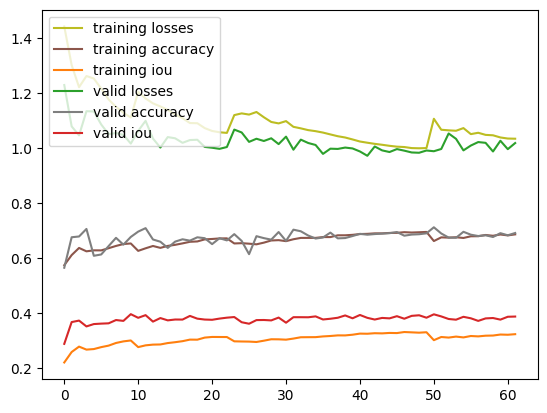

None

max valid iou: 0.39725426050384394


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0
running_mae = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
training_mae = []
valid_losses = []
valid_accuracies = []
valid_ious = []
valid_mae = []

for i in range(start, 333):
  train_validation_loop_multilabel(net, optimizer, scheduler, train_loader, valid_loader, 3, i)
  epochs.append(i)
  x = epochs


  #   # Ensure data for plotting is on CPU and in numpy format
  training_losses_np = [loss for loss in training_losses]  # are not tensors
  valid_losses_np = [loss.item() for loss in valid_losses] # because we save all losses --> but print only the total loss (equally weighted)


  #if AUXILIARY_DATASOURCE == 'LC' or AUXILIARY_DATASOURCE == 'POP':
  training_accuracies_np = [acc for acc in training_accuracies]  # are not tensors
  training_ious_np = [iou for iou in training_ious] # item because ious are saved as tensors
  valid_accuracies_np = [acc for acc in valid_accuracies]
  valid_ious_np = [iou for iou in valid_ious]

  plt.plot(x, training_losses_np, 'tab:olive', label='training losses')
  plt.plot(x, training_accuracies_np, 'tab:brown', label='training accuracy')
  plt.plot(x, training_ious_np, 'tab:orange', label='training iou')
  plt.plot(x, valid_losses_np, 'tab:green',label='valid losses')
  plt.plot(x, valid_accuracies_np, 'tab:grey', label='valid accuracy')
  plt.plot(x, valid_ious_np, 'tab:red', label='valid iou')

  plt.legend(loc="upper left")
  plt.show()

  display(plt.show())
  print("max valid iou:", max_valid_iou)

  if i % 10 == 0 and i != 0:
    save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
    #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, i, max_valid_iou)
    torch.save(net.state_dict(), save_path)


In [ ]:
# save the model at the end as well, the one with highest iou
save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, LR, 'last_iteration')
torch.save(net.state_dict(), save_path)

## 6. Look at outputs

In [ ]:
def visualize_segmentation_example_within_loop(images, labels, i):
  images, labels = images.cuda(), labels.cuda()

  # Obtain the model's predictions.
  outputs = net(images)
  # Assuming the outputs are raw logits, apply softmax to obtain probabilities.
  probs = torch.softmax(outputs, dim=1)
  # Convert probabilities to predicted class labels.
  predicted_masks = torch.argmax(probs, dim=1)

  # Move the tensors to the CPU for visualization.
  images, labels, predicted_masks = images.cpu(), labels.cpu(), predicted_masks.cpu()

  # Convert the first image and masks to PIL images for easy visualization.
  original_image = to_pil_image(images[0])
  true_mask = to_pil_image(labels[0].unsqueeze(0).float())  # Adding channel dimension for compatibility.
  predicted_mask = to_pil_image(predicted_masks[0].unsqueeze(0).byte())
  print(predicted_mask.size)

  # Visualization
  fig, ax = plt.subplots(1, 3, figsize=(20, 10))
  ax[0].imshow(images[0][0], cmap=cmap_sar, vmin=-4, vmax=4)
  ax[0].set_title('Original Image Band 1')
  ax[0].axis('off')

  ax[1].imshow(true_mask)
  ax[1].set_title('True Mask')
  ax[1].axis('off')

  ax[2].imshow(predicted_mask)
  ax[2].set_title('Predicted Mask')
  ax[2].axis('off')

  #fig.savefig(os.path.join(fig_save_path, f"{i}__combined_figure.png"))

  plt.show()

  plt.close(fig)


In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm


cmap_lc = plt.get_cmap('tab20', 18)  # 'tab20' has 20 distinct colors

# Create a mapping from class_id to color
class_to_color = {class_id: cmap_lc(class_id) for class_id in range(18)}

from matplotlib.colors import ListedColormap


colors = [cmap_lc(i) for i in range(6)]
cmap_built = ListedColormap(colors)

# this only makes sense if the label is LC
def visualize_segmentation_example_multilabel(net, test_data_loader):
    net.eval()  # Ensure the model is in evaluation mode.
    net.cuda()  # Ensure the model operates on the GPU.

    with torch.no_grad():  # Disable gradient computation for efficiency.
        # Iterating over the test dataset to get a single batch.
        for images, labels in tqdm(test_data_loader):

            images = images.cuda()
            outputs = net(images) # [6, 25, 256, 256]


            label = labels[:, 0, :, :] # dimension as [batch_size, height, width], i.e. removed the single dimension as cross entropy expects [batch size, height, width]
            label = label.cuda()
            # Assuming the outputs of the classification task are raw logits, apply softmax to obtain probabilities.
            probs_lc = torch.softmax(outputs, dim=1)
            # Convert probabilities to predicted class labels.
            predicted_masks_lc = torch.argmax(probs_lc, dim=1)
            # move it to CPU for vis
            predicted_masks_lc = predicted_masks_lc.cpu()

            # Move the tensors to the CPU for visualization.
            images, label = images.cpu(), label.cpu()


            print(label[0])
            true_mask = to_pil_image(label[0].float()) #.float() # Adding channel dimension for compatibility. # this could be an error, maybe leave the unsqueeze part away
            print(predicted_masks_lc[0])
            predicted_mask = to_pil_image(predicted_masks_lc[0].unsqueeze(0).byte())

            composite_image = torch.stack([images[0, 3], images[0, 2], images[0, 1]], dim=-1)

            # Visualization
            fig, ax = plt.subplots(2, 2, figsize=(20, 10))

            ax[0,0].imshow(composite_image)
            ax[0,0].set_title('Original Image RGB')
            ax[0,0].axis('off')

            ax[1,0].imshow(images[0][0], vmin=-4, vmax=4) # second row, first column
            ax[1,0].set_title('Original Image Band 2')
            ax[1,0].axis('off')

            img_1 = ax[0,1].imshow(label[0], cmap_lc, vmin=0, vmax=17)
            ax[0,1].set_title(f'True Mask {AUXILIARY_DATASOURCE}')
            ax[0,1].axis('off')

            img_2 = ax[1,1].imshow(predicted_mask, cmap_lc, vmin=0, vmax=17)
            ax[1,1].set_title(f'Predicted Mask {AUXILIARY_DATASOURCE}')
            ax[1,1].axis('off')

            plt.colorbar(img_1, ticks=range(18))
            plt.colorbar(img_2, ticks=range(18))

            plt.show()




In [ ]:
# load a net and look at visualisations
model = smp.Unet(encoder_name='resnet18', encoder_weights=None, in_channels=13, classes = 18)
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
checkpoints = os.listdir(model_save_path)
state_dict = torch.load(model_save_path + 'pretext_eurosat_allData_lr001LC_40_0.7260022206156778.cp')
model.load_state_dict(state_dict)

<All keys matched successfully>

  0%|          | 0/20 [00:00<?, ?it/s]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)
tensor([[1, 1, 1,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 1, 2, 2],
        [1, 1, 1,  ..., 1, 1, 2],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


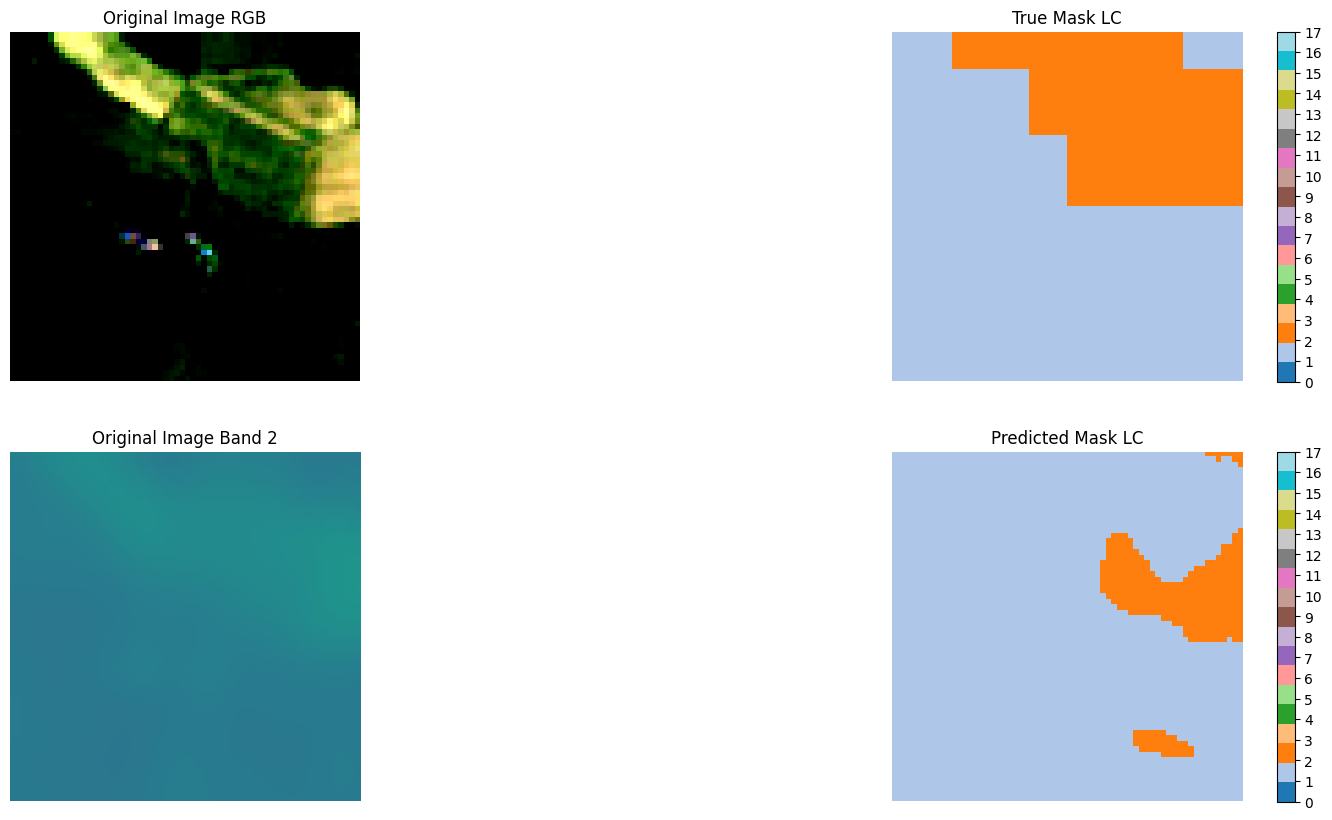

tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]], dtype=torch.int32)
tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]])


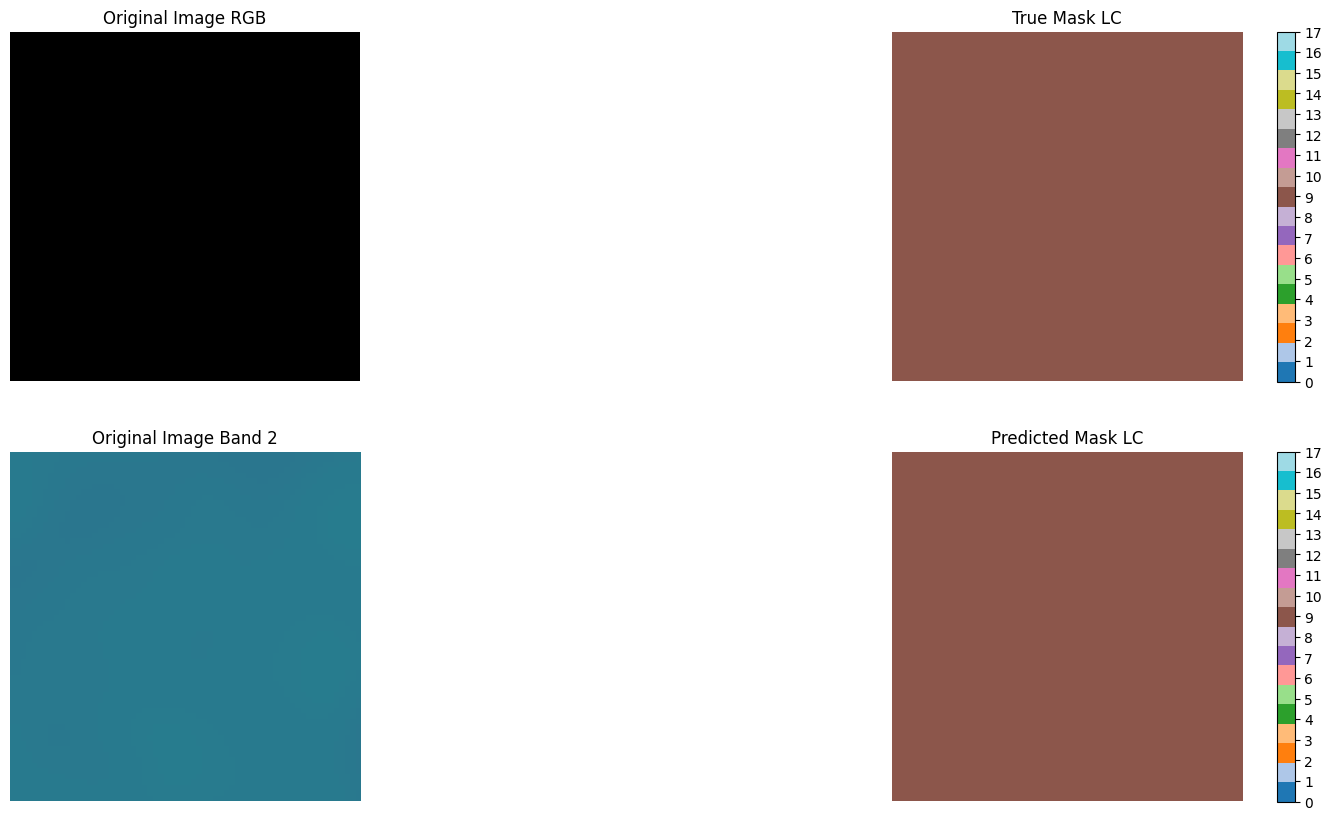

tensor([[3, 3, 3,  ..., 2, 2, 2],
        [3, 3, 3,  ..., 2, 2, 2],
        [3, 3, 3,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32)
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 3],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 3]])


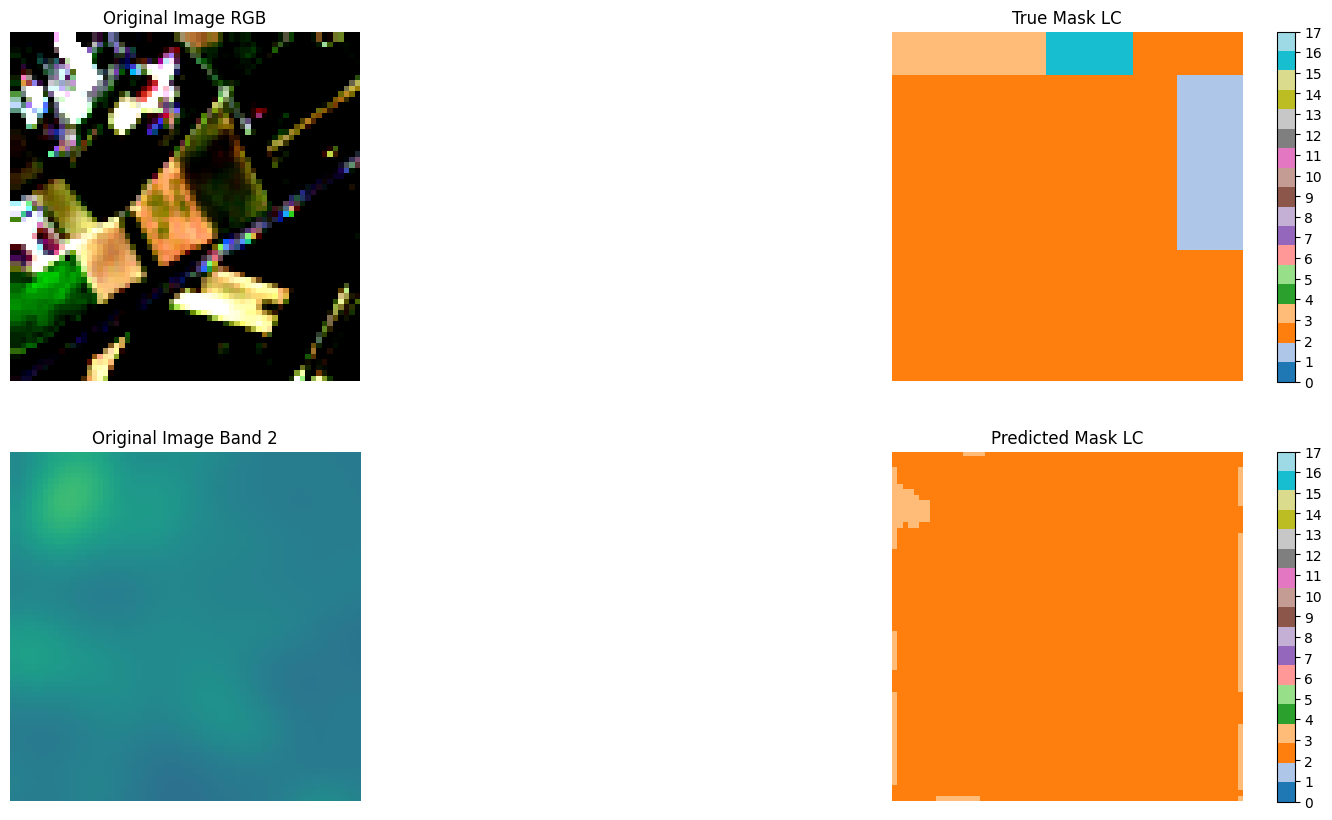

tensor([[ 2,  2,  2,  ..., 15, 15, 15],
        [ 2,  2,  2,  ..., 15, 15, 15],
        [ 2,  2,  2,  ..., 15, 15, 15],
        ...,
        [ 2,  2,  2,  ...,  2,  2,  2],
        [ 2,  2,  2,  ...,  2,  2,  2],
        [ 2,  2,  2,  ...,  2,  2,  2]], dtype=torch.int32)
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])


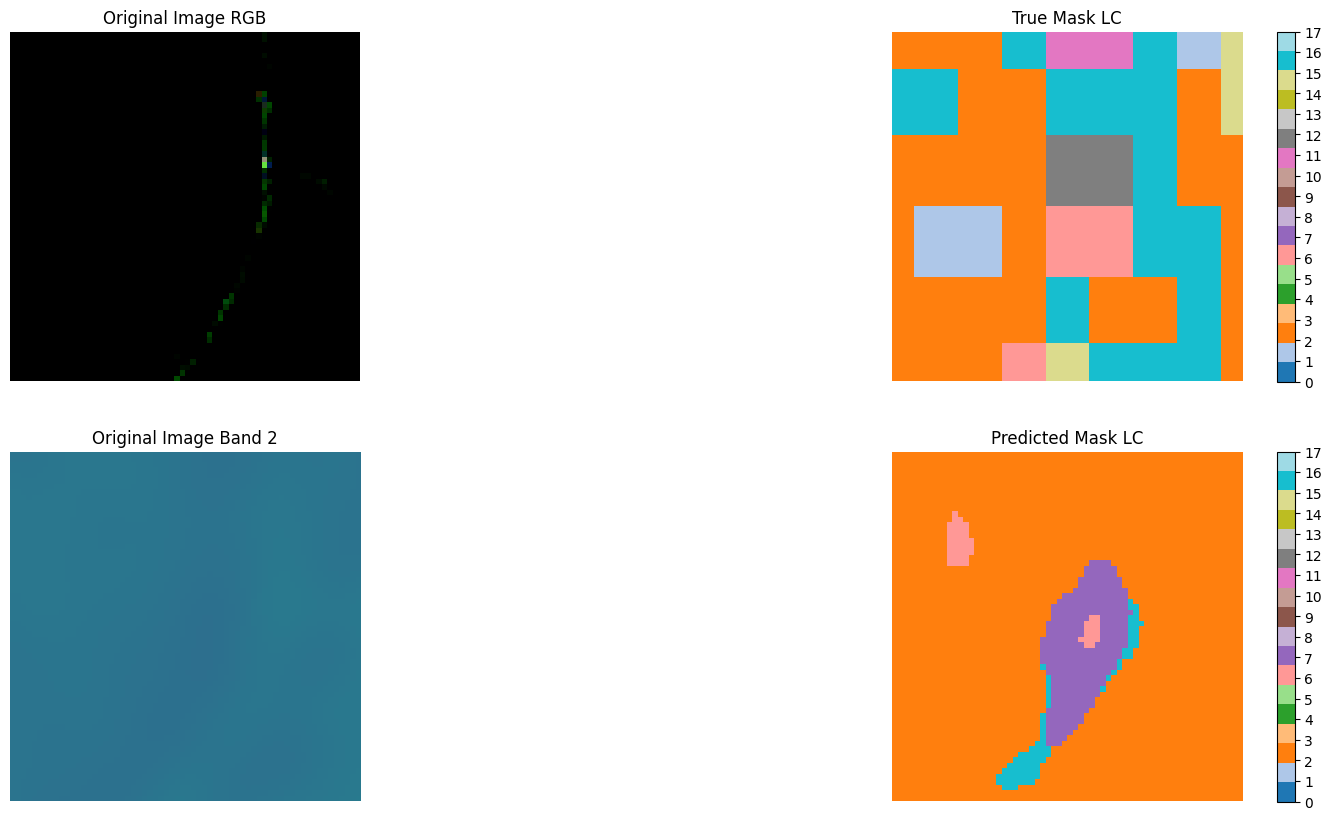

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32)
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])


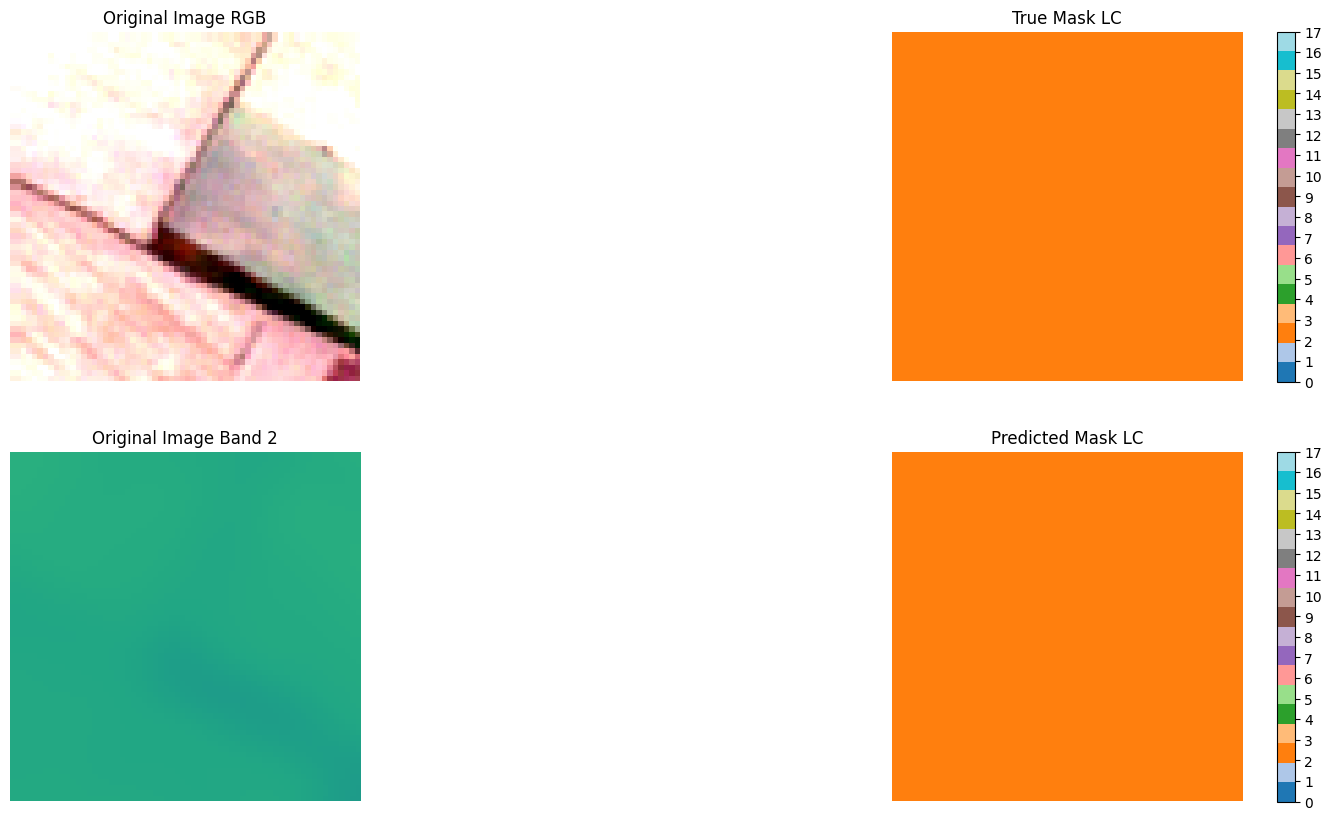

tensor([[ 2,  2,  2,  ...,  3,  3,  3],
        [ 2,  2,  2,  ...,  3,  3,  3],
        [ 2,  2,  2,  ...,  3,  3,  3],
        ...,
        [ 3,  3,  3,  ..., 16, 16, 16],
        [ 3,  3,  3,  ..., 16, 16, 16],
        [ 3,  3,  3,  ..., 16, 16, 16]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


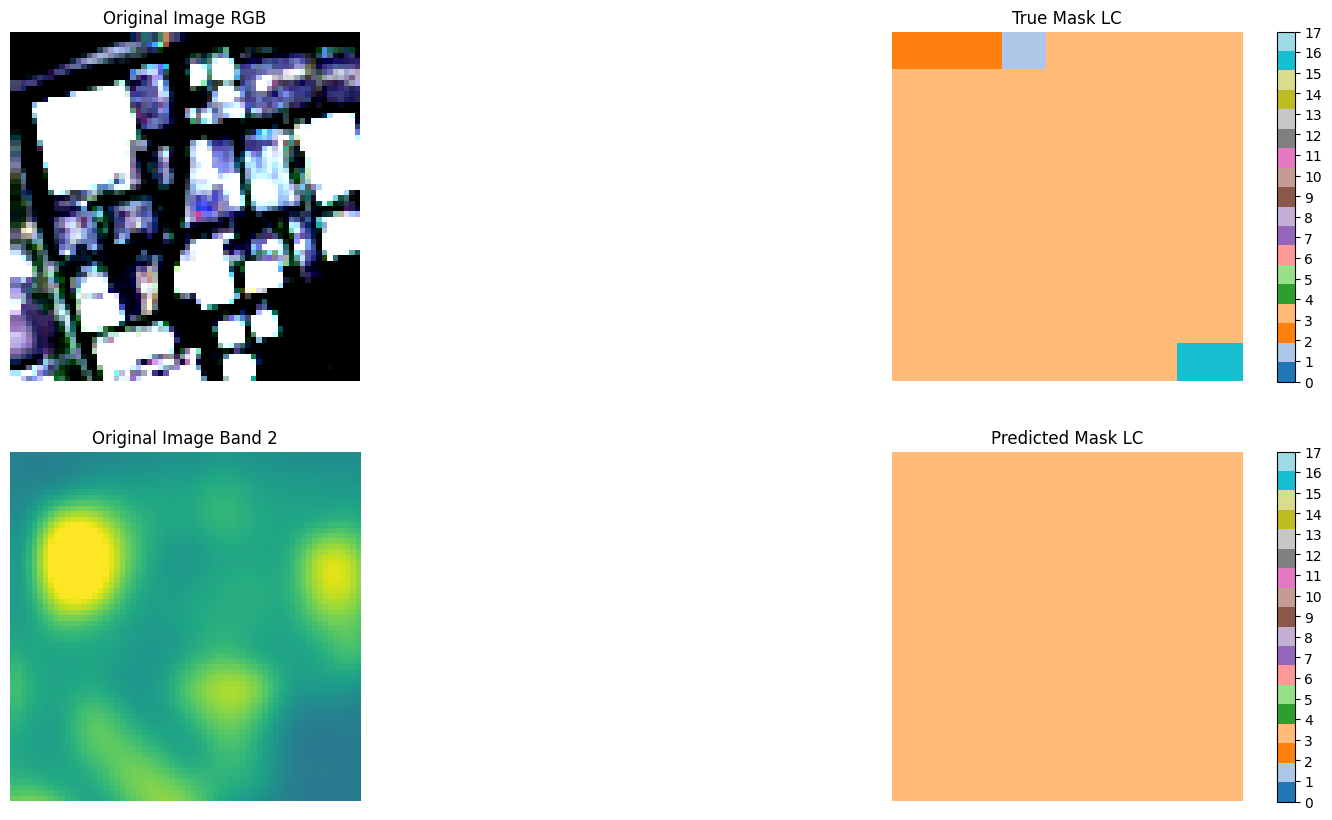

tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]], dtype=torch.int32)
tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]])


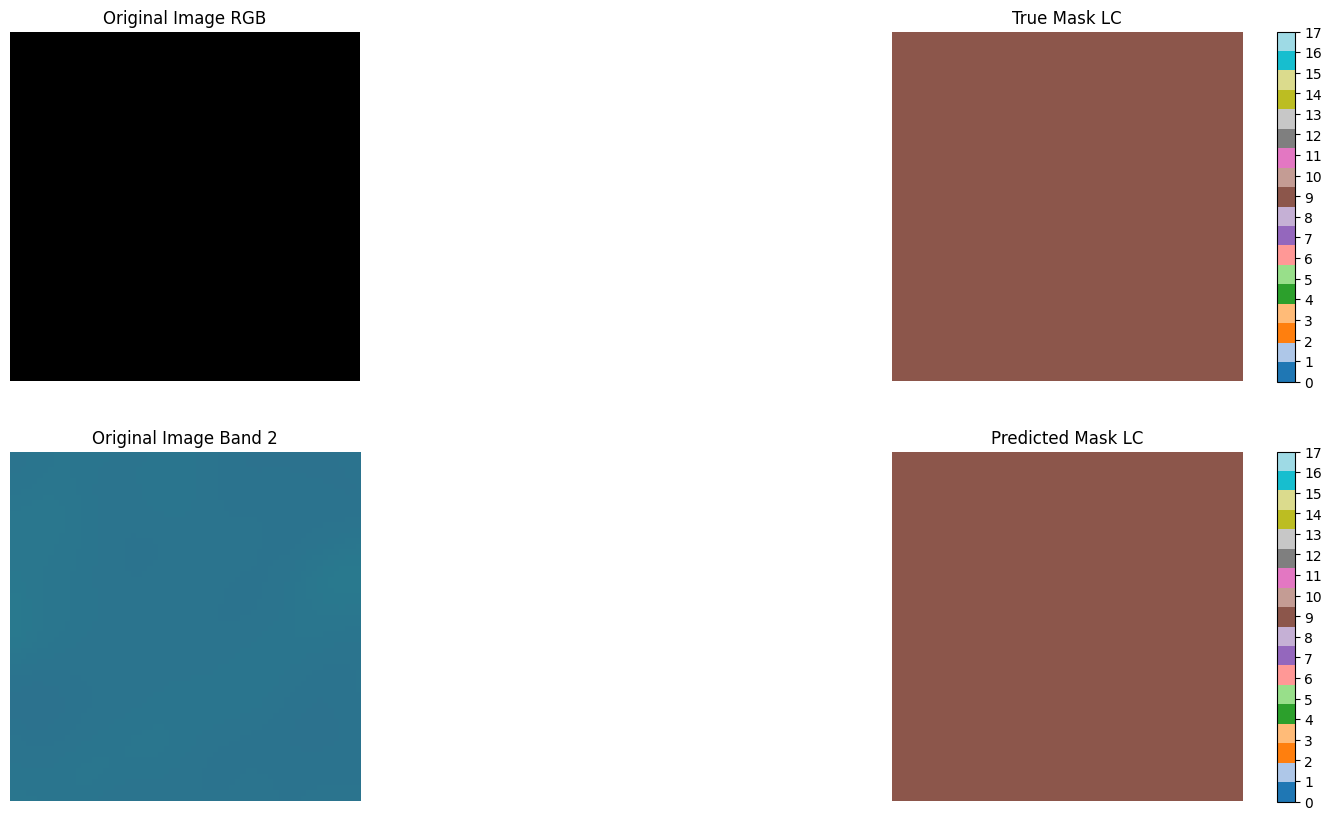

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32)
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])


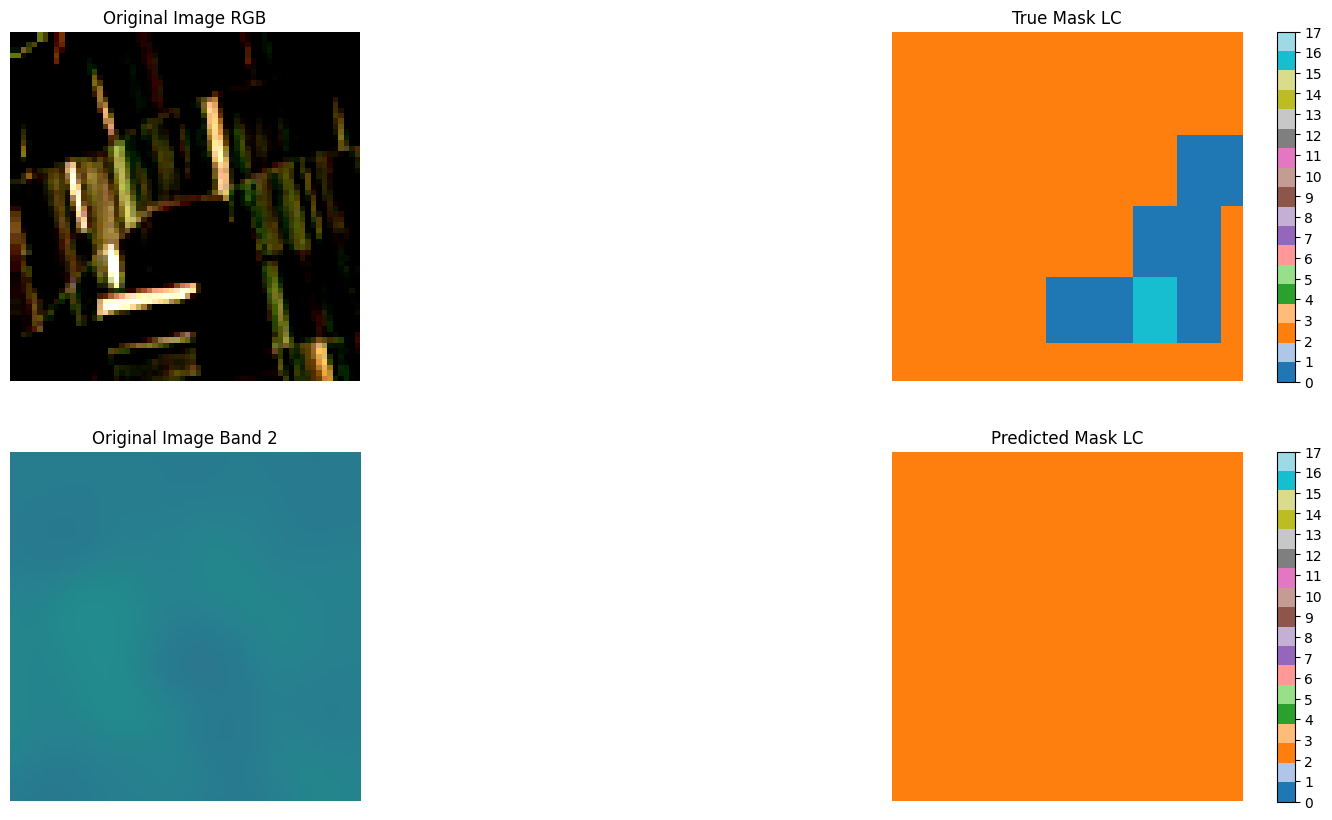

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


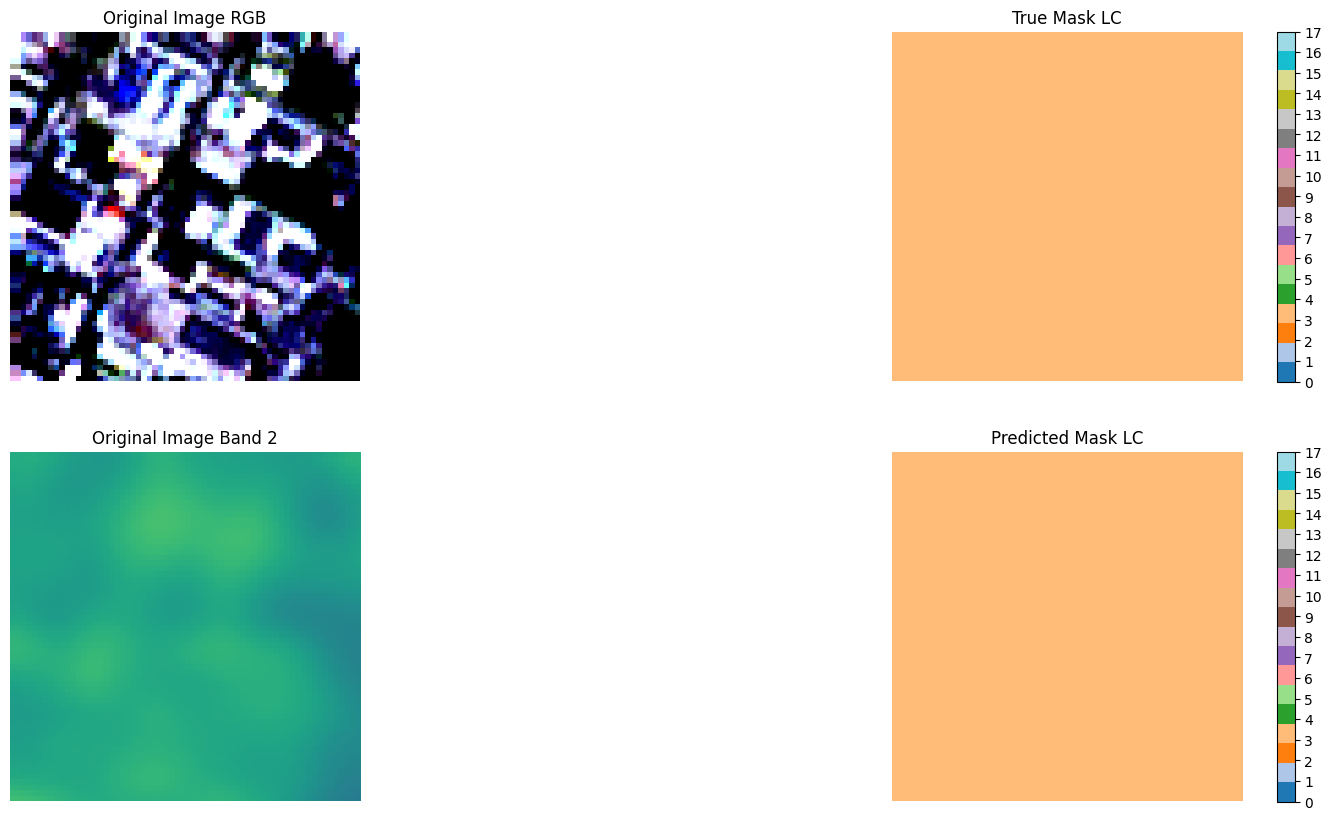

tensor([[10, 10, 10,  ..., 11, 11, 11],
        [10, 10, 10,  ..., 11, 11, 11],
        [10, 10, 10,  ..., 11, 11, 11],
        ...,
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10]], dtype=torch.int32)
tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10]])


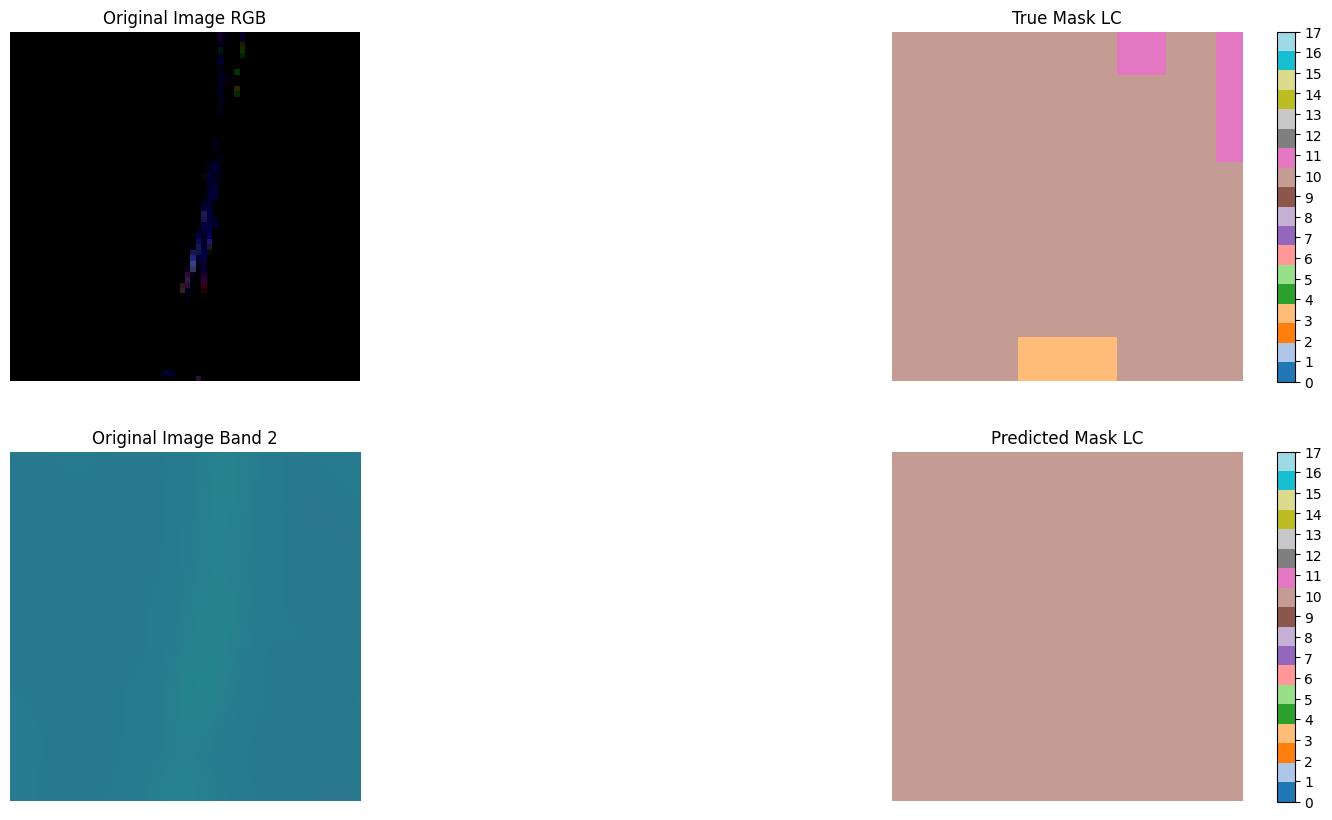

tensor([[ 6,  6,  6,  ...,  6,  6,  6],
        [ 6,  6,  6,  ...,  6,  6,  6],
        [ 6,  6,  6,  ...,  6,  6,  6],
        ...,
        [ 6,  6,  6,  ..., 11, 11, 11],
        [ 6,  6,  6,  ..., 11, 11, 11],
        [ 6,  6,  6,  ..., 11, 11, 11]], dtype=torch.int32)
tensor([[6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        ...,
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6]])


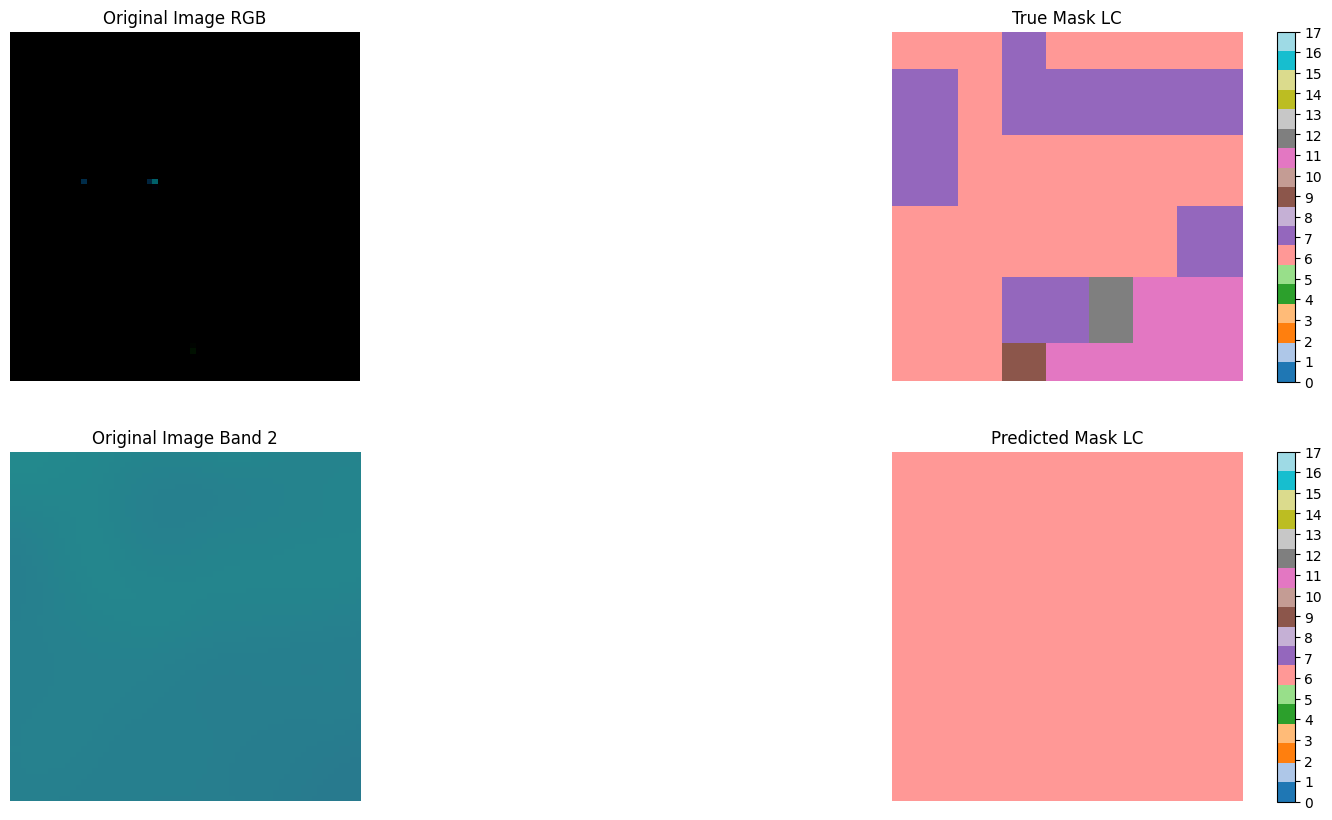

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


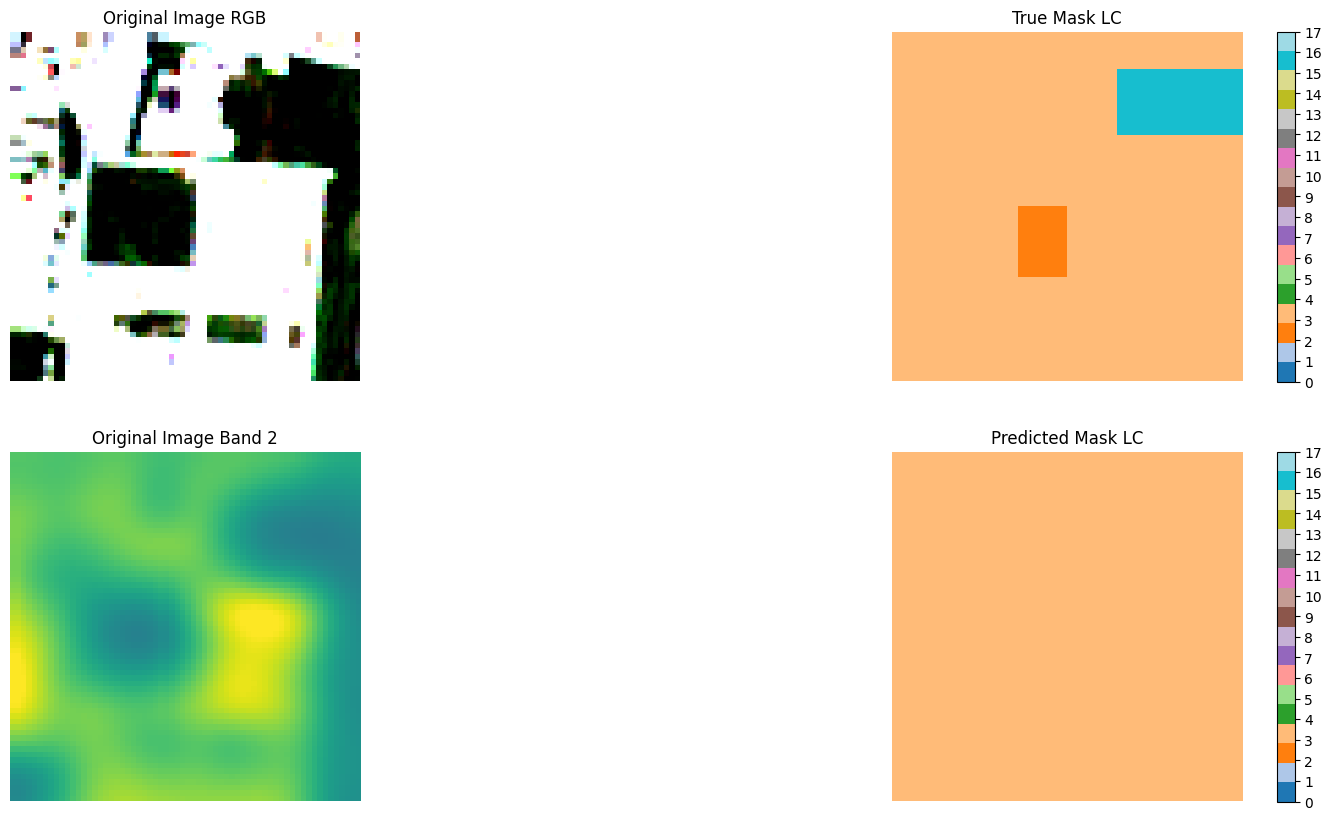

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


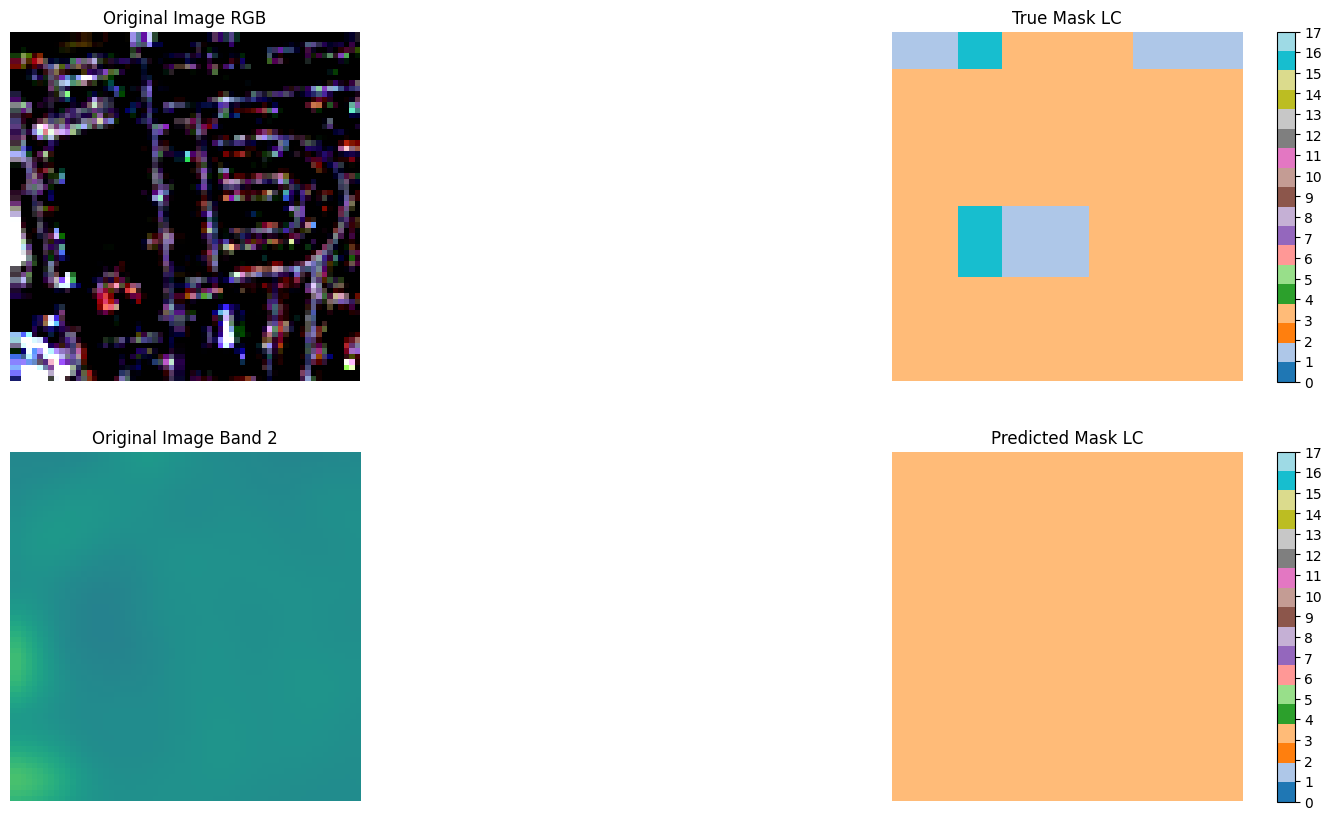

tensor([[16, 16, 16,  ..., 16, 16, 16],
        [16, 16, 16,  ..., 16, 16, 16],
        [16, 16, 16,  ..., 16, 16, 16],
        ...,
        [16, 16, 16,  ...,  2,  2,  2],
        [16, 16, 16,  ...,  2,  2,  2],
        [16, 16, 16,  ...,  2,  2,  2]], dtype=torch.int32)
tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])


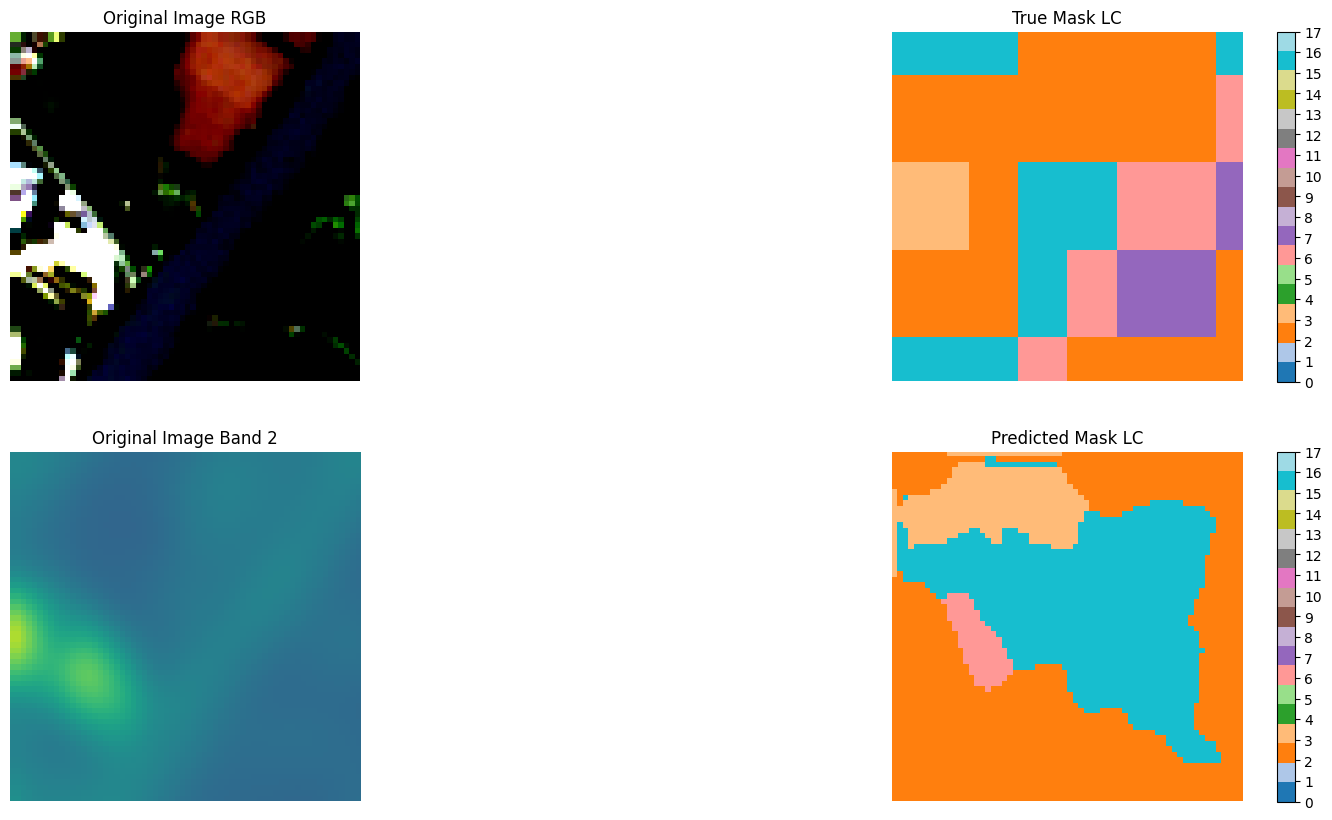

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 2, 2, 2],
        [3, 3, 3,  ..., 2, 2, 2],
        [3, 3, 3,  ..., 2, 2, 2]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


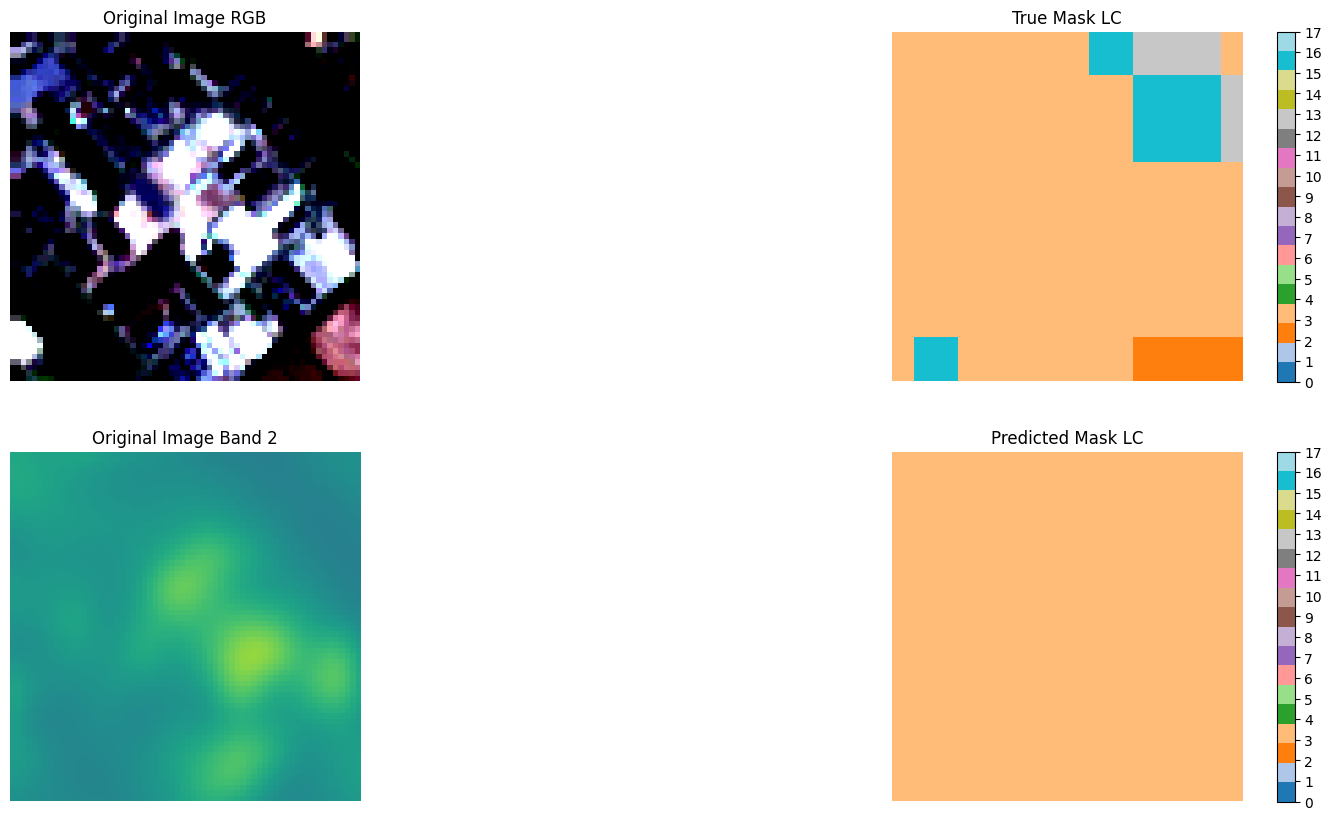

tensor([[10, 10, 10,  ...,  6,  6,  6],
        [10, 10, 10,  ...,  6,  6,  6],
        [10, 10, 10,  ...,  6,  6,  6],
        ...,
        [ 7,  7,  7,  ..., 10, 10, 10],
        [ 7,  7,  7,  ..., 10, 10, 10],
        [ 7,  7,  7,  ..., 10, 10, 10]], dtype=torch.int32)
tensor([[6, 6, 6,  ..., 6, 2, 2],
        [6, 6, 6,  ..., 6, 2, 2],
        [6, 6, 6,  ..., 6, 6, 6],
        ...,
        [2, 2, 2,  ..., 6, 2, 6],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])


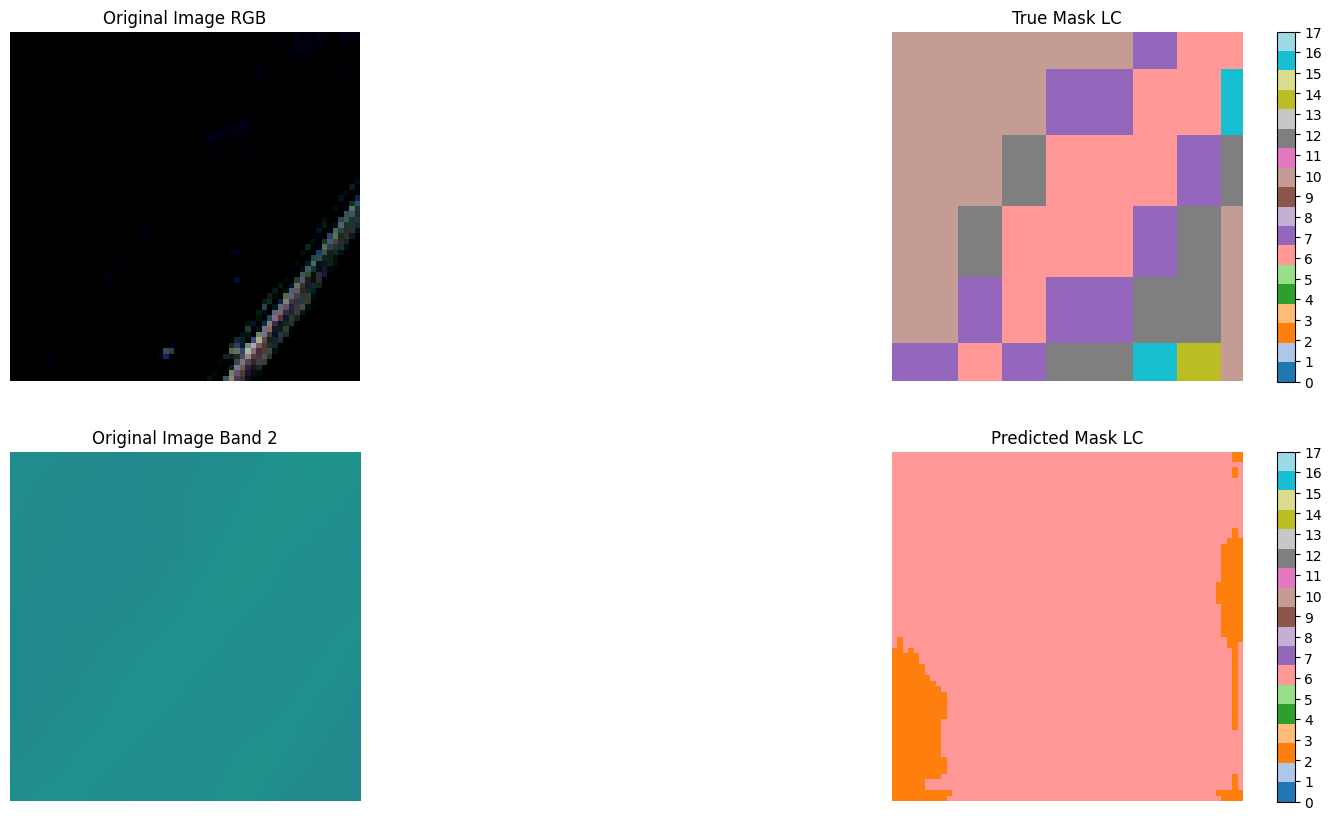

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


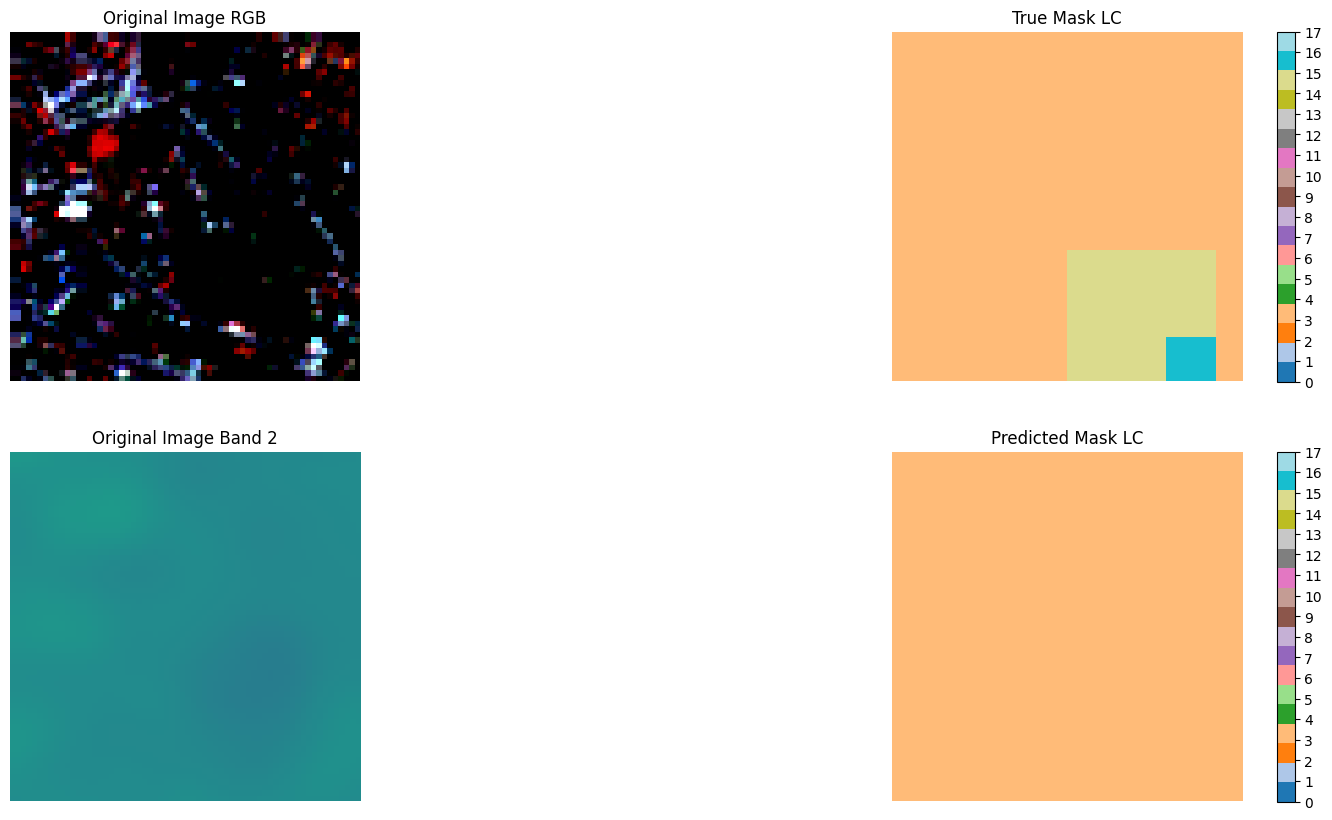

tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10]], dtype=torch.int32)
tensor([[10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10]])


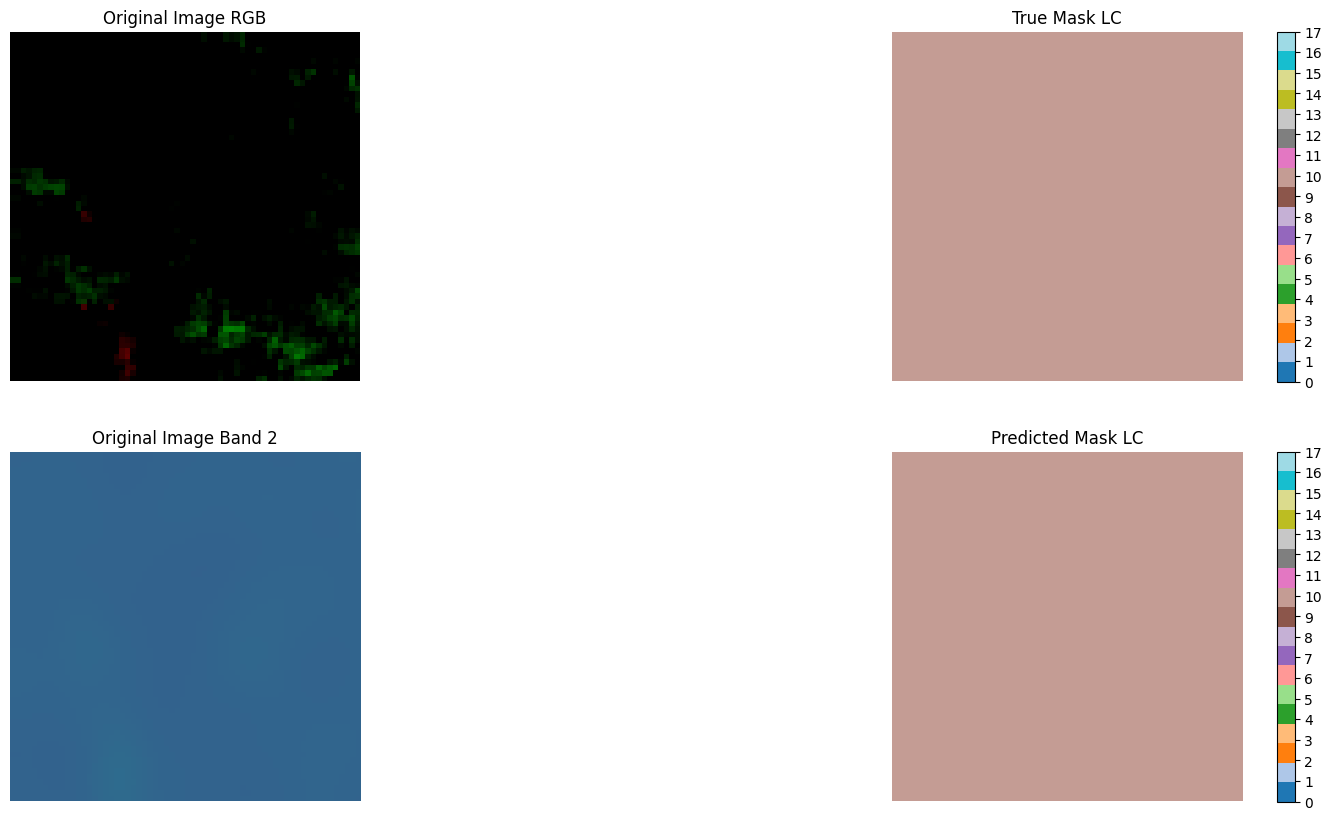

tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.int32)
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


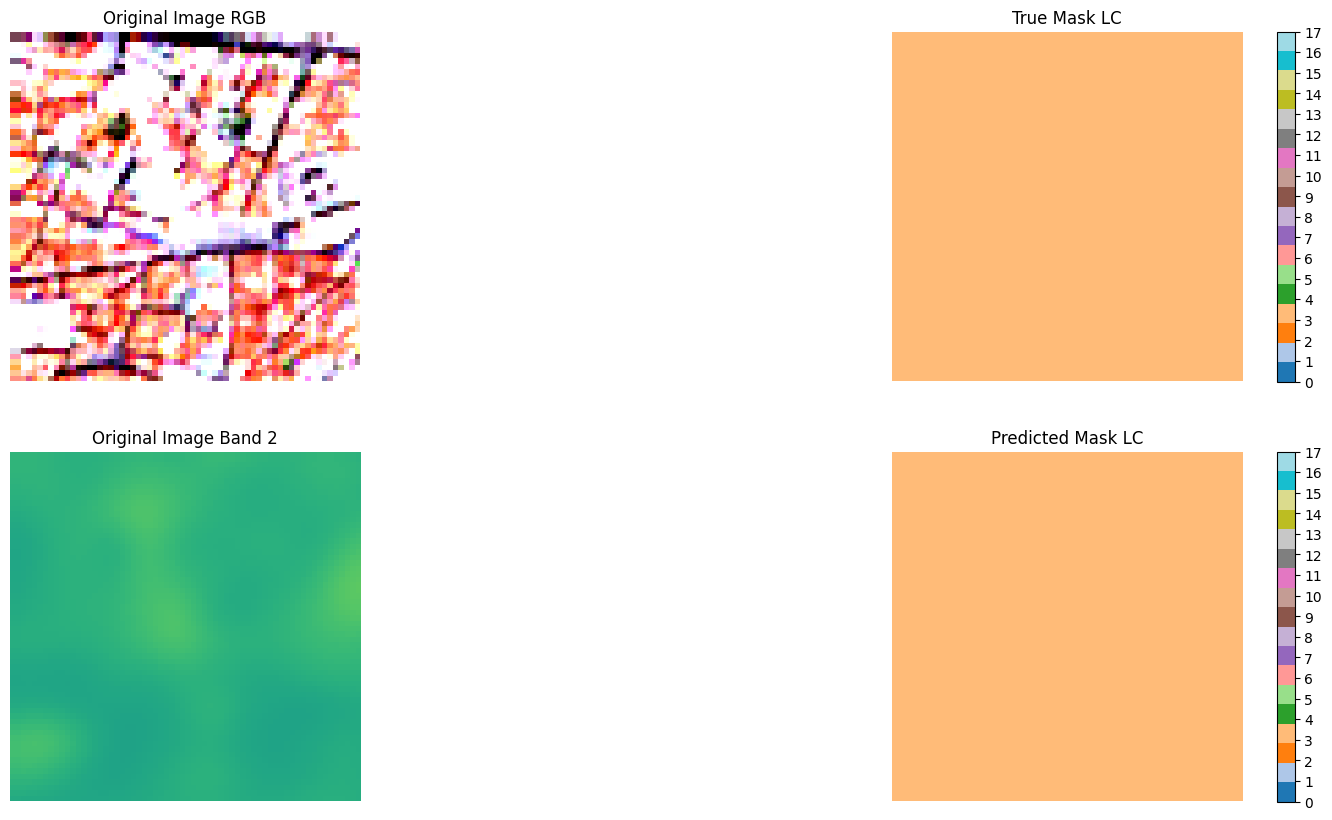

tensor([[ 1,  1,  1,  ..., 16, 16, 16],
        [ 1,  1,  1,  ..., 16, 16, 16],
        [ 1,  1,  1,  ..., 16, 16, 16],
        ...,
        [ 3,  3,  3,  ...,  2,  2,  2],
        [ 3,  3,  3,  ...,  2,  2,  2],
        [ 3,  3,  3,  ...,  2,  2,  2]], dtype=torch.int32)
tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [ 2,  2,  2,  ...,  2,  2,  2],
        [ 2,  2,  2,  ..., 16,  2,  2],
        ...,
        [ 2,  2,  2,  ...,  2,  2,  2],
        [ 2,  2,  2,  ...,  2,  2,  2],
        [ 2,  2,  2,  ...,  2,  2,  2]])


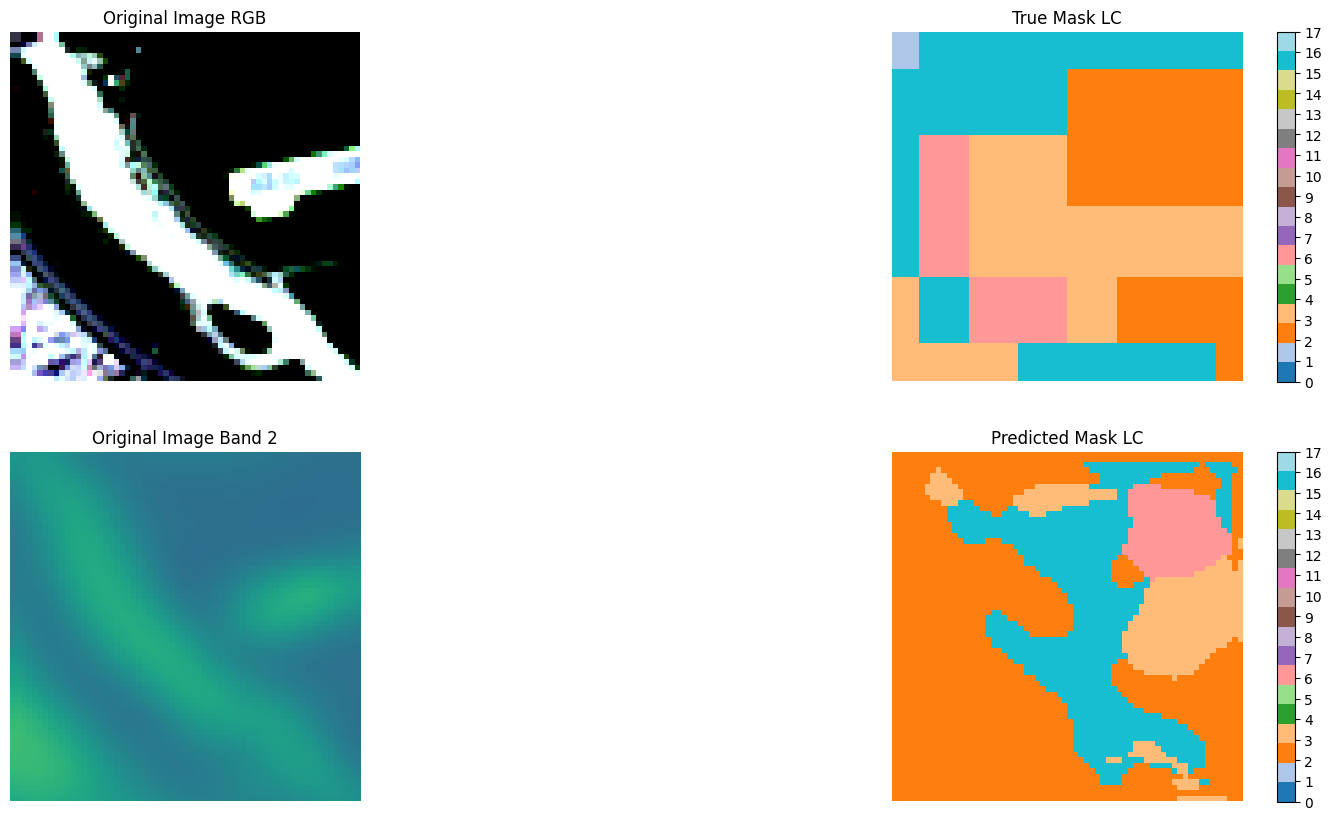

In [ ]:
#for i in range(6):
visualize_segmentation_example_multilabel(model, valid_loader)